In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum
# from pynrc.obs_nircam import model_to_hdulist, obs_hci
# from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [199]:
S.showref()

graphtable: /Users/jwstnircam/NIRCam/cdbs.20.1rc1/mtab/yah1742qm_tmg.fits
 comptable: /Users/jwstnircam/NIRCam/cdbs.20.1rc1/mtab/z4k1425fm_tmc.fits
thermtable: /Users/jwstnircam/NIRCam/cdbs.20.1rc1/mtab/tae17277m_tmt.fits
      area: 254000.0
   waveset: Min: 500, Max: 56000, Num: 10000, Delta: None, Log: False


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import do_plot_contrasts
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

In [4]:
def plot_compare2(curves_all, obs_dict, filt_keys, wfe_list, age, nsig=5, sat_max=[0,0],
                  label1='Direct Imaging', label2='Coronagraphy', xr=[0,5], **kwargs):

    fig, axes = plt.subplots(1,2, figsize=(13,5))

    lin_vals = np.linspace(0.2,0.8,len(wfe_list))
    c1 = plt.cm.Blues_r(lin_vals)
    c2 = plt.cm.Reds_r(lin_vals)
    c3 = plt.cm.Purples_r(lin_vals)
    c4 = plt.cm.Greens_r(lin_vals)


    # Left plot (5-sigma sensitivities)
    ax = axes[0]
    yr = [24,8]

    k = filt_keys[0]
    curves = curves_all[k]
    obs = obs_dict[k]
    ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=sat_max[0],
                                  ax=ax, colors=c1, xr=xr, yr=yr, return_axes=True)
    # Planet mass locations
    plot_planet_patches(ax, obs, age=age, update_title=True, **kwargs)

    k = filt_keys[1]
    curves = curves_all[k]
    obs = None
    plot_contrasts(curves, nsig, wfe_list, obs=obs, sat_rad=sat_max[1], 
                   ax=ax, xr=xr, yr=yr, colors=c2)



    # Right plot (Converted to MJup)
    ax = axes[1]
    k = filt_keys[0]
    curves = curves_all[k]
    obs = obs_dict[k]
    ax, ax3 = plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=sat_max[0], 
                             ax=ax, colors=c1, xr=xr, twin_ax=True, return_axes=True)

    k = filt_keys[1]
    curves = curves_all[k]
    obs = obs_dict[k]
    plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age, sat_rad=sat_max[1], 
                        ax=ax, colors=c2, xr=xr)

    ax.set_title('{} Mass Sensitivities -- COND Models'.format(obs.filter))

    
    # Some fancy log+linear plotting
    from matplotlib.ticker import FixedLocator, ScalarFormatter
    ax = axes[1]
    ax.set_ylim([0,100])
    yr = ax.get_ylim()
    ax.set_yscale('symlog', linthreshy=10, linscaley=2)
    ax.set_yticks(list(range(0,10)) + [10,100,1000])
    ax.yaxis.set_major_formatter(ScalarFormatter())

    minor_log = list(np.arange(20,100,10)) + list(np.arange(200,1000,100))
    minorLocator = FixedLocator(minor_log)
    ax.yaxis.set_minor_locator(minorLocator)
    ax.set_ylim([0,yr[1]])


    # Left legend
    nwfe = len(wfe_list)
    ax=axes[0]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h3 = handles[2*nwfe:]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    handles_new = h1_t + h1 + h2_t + h2 + h3
    ax.legend(ncol=3, handles=handles_new, loc=1, fontsize=9)

    # Right legend
    ax=axes[1]
    handles, labels = ax.get_legend_handles_labels()
    h1 = handles[0:nwfe][::-1]
    h2 = handles[nwfe:2*nwfe][::-1]
    h1_t = [mpatches.Patch(color='none', label=label1)]
    h2_t = [mpatches.Patch(color='none', label=label2)]
    handles_new = h1_t + h1 + h2_t + h2
    ax.legend(ncol=2, handles=handles_new, loc=1, fontsize=9)



    # Title
    dist = obs.distance
    age_str = 'Age = {:.0f} Myr'.format(age)
    dist_str = 'Distance = {:.1f} pc'.format(dist) if dist is not None else ''
    title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

    fig.suptitle(title_str, fontsize=16);

    fig.tight_layout()
    fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.97)

    return (fig, axes)

In [5]:
def disk_rim_model(a_asec, b_asec, pa=0, sig_asec=0.1, flux_frac=0.5,
                   flux_tot=1.0, flux_units='mJy', wave_um=None, dist_pc=None,
                   pixsize=0.007, fov_pix=401):
    """
    Simple geometric model of an inner disk rim that simply creates an
    ellipsoidal ring with a brightness gradient along the major axis.
    """
    
    
    from astropy.modeling.models import Ellipse2D
    from astropy.convolution import Gaussian2DKernel, convolve_fft
    from astropy.io import fits

    
    # Get polar and cartesian pixel coordinates
    sh = (fov_pix, fov_pix)
    r_pix, th_ang = nrc_utils.dist_image(np.ones(sh), return_theta=True)
    x_pix, y_pix = nrc_utils.rtheta_to_xy(r_pix, th_ang)

    
    # In terms of arcsec
    x_asec = pixsize * x_pix
    y_asec = pixsize * y_pix
    r_asec = pixsize * r_pix
    
    
    # Semi major/minor axes (pix)
    a_pix = a_asec / pixsize
    b_pix = b_asec / pixsize

    # Create ellipse functions
    e1 = Ellipse2D(theta=0, a=a_pix+1, b=b_pix+1)
    e2 = Ellipse2D(theta=0, a=a_pix-1, b=b_pix-1)
    
    # Make the two ellipse images and subtract
    e1_im = e1(x_pix,y_pix)
    e2_im = e2(x_pix,y_pix)
    e_im = e1_im - e2_im

    # Produce a brightness gradient along major axis
    grad_im = (1-flux_frac) * np.abs(x_pix) / a_pix + flux_frac
    e_im = e_im * grad_im
    
    # Convolve image with Gaussian to simulate scattering
    sig_pix = sig_asec / pixsize
    kernel = Gaussian2DKernel(sig_pix)
    e_im = convolve_fft(e_im, kernel)

    # Rotate
    th_deg = pa - 90.
    e_im = nrc_utils.rotate_offset(e_im, angle=-th_deg, order=3, reshape=False)
    
    e_im = flux_tot * e_im / np.sum(e_im)
    
    hdu = fits.PrimaryHDU(e_im)
    hdu.header['PIXELSCL'] = (pixsize, "Pixel Scale (asec/pix)")
    hdu.header['UNITS'] = "{}/pixel".format(flux_units)
    if wave_um is not None:
        hdu.header['WAVE'] = (wave_um, "Wavelength (microns)")
    if dist_pc is not None:
        hdu.header['DISTANCE'] = (dist_pc, "Distance (pc)")
        
    return fits.HDUList([hdu])

## Define Sources and their Reference PSF Stars

In [6]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [7]:
#                source,      dist, age, sptype,  vmag kmag  W1   W2
args_sources = [('PDS 70',     113,  10,'K7IV',  12.2, 8.8, 8.0, 7.7)]

ref_sources = args_sources

In [8]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'YSOs/'

In [9]:
# List of filters
args_filter = [('F444W',       None,       None),
               ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## SED Fit

In [10]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, vmag_sci, kmag_sci, w1_sci, w2_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

mag_sci, bp_sci = vmag_sci, bp_v
args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
src = source_spectrum(*args)

src.fit_SED(use_err=False, robust=False, wlim=[1,10], IR_excess=True)

# Final source spectrum
sp_sci = src.sp_model

[2.62066110e-08 1.06733367e+07 3.54856009e+00]


In [11]:
# Do the same for the reference source
name_ref, spt_ref, sp_ref = name_sci, spt_sci, sp_sci

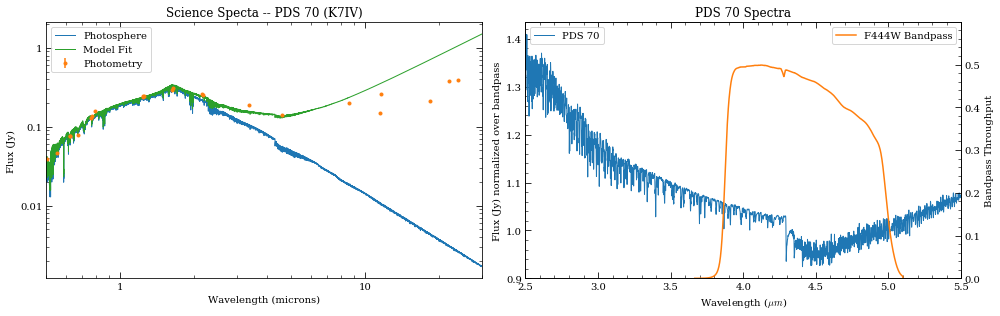

In [12]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
src.plot_SED(ax=axes[0], xr=[0.5,30])
ax.set_title('Science Specta -- {} ({})'.format(name_sci, spt_sci))
# ax.set_xscale('linear')
# ax.xaxis.set_minor_locator(AutoMinorLocator())


ax = axes[1]
xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
sp = sp_sci
w = sp.wave / 1e4
o = S.Observation(sp, bp, binset=bp.wave)
sp.convert('Jy')
f = sp.flux / o.effstim('Jy')

ind = (w>=xr[0]) & (w<=xr[1])
ax.plot(w[ind], f[ind], lw=1, label=sp.name)
ax.set_ylabel('Flux (Jy) normalized over bandpass')
sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C1', label=bp.name+' Bandpass')
ax2.set_ylim([0,1.2*bp.throughput.max()])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SED_compare.pdf'.format(name_sci.replace(' ','')))


### Generate observations

In [12]:
# Disk Model

# Semi major/minor axes (AU)
a = 137.0 / 2.
b = 88.6 / 2.

# Position angle 
pa = 158.6

# Assume distance for the a/b values
dist_assume = 140

# Semi major/minor axes (arcsec)
a_asec = a / dist_assume
b_asec = b / dist_assume

flux = 11.2 # mJy
wave_um = 4 # um
hdul = disk_rim_model(a_asec, b_asec, pa=pa, sig_asec=0.08, flux_frac=0.5, 
                      flux_tot=flux, flux_units='mJy', wave_um=wave_um, dist_pc=dist_sci)

hdr = hdul[0].header
args_disk = (hdul, hdr['PIXELSCL'], dist_sci, wave_um, hdr['UNITS'])

In [13]:
subsize = None

# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)


F444W_none_none
F444W_MASK335R_CIRCLYOT


In [14]:
# if there's a disk input, then we want to remove disk 
# contributions from stellar flux and recompute to make 
# sure total flux counts matches what we computed for 
# sp_sci in previous section to match real photometry
if args_disk is not None:
    for key in filt_keys:
        obs = obs_dict[key]
        
        star_flux = obs.star_flux(sp=sp_sci) # Pass original input spectrum
        disk_flux = obs.disk_hdulist[0].data.sum()
        obs.sp_sci = sp_sci * (1 - disk_flux / star_flux)
        obs.sp_sci.name = sp_sci.name
        
        obs.sp_ref = obs.sp_sci

In [188]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',5,120,120)

#         pattern, ng, nint_sci, nint_ref = ('RAPID',10,120,120)
        obs.update_detectors(xpix=400, ypix=400)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,15,15)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F444W_none_none
{'t_frame': 1.65624, 't_group': 1.65624, 't_int': 8.2812, 't_exp': 993.744, 't_acq': 1194.9647999999997, 't_int_tot1': 9.958039999999999, 't_int_tot2': 9.958039999999999}
Point Source Sensitivity (5-sigma): 22.61 vegamag
Surface Brightness Sensitivity (5-sigma): 20.55 vegamag/arcsec^2

F444W_MASK335R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1571.4887999999999, 't_acq': 1587.8232, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.75 vegamag/arcsec^2



### Saturation 

In [166]:
k = filt_keys[0]
obs = obs_dict[k]

obs.update_detectors(xpix=160, ypix=160, ngroup=10, nint=500)
obs.nrc_ref.update_detectors(xpix=160, ypix=160, ngroup=10, nint=500)

print(obs.multiaccum_times)

{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1393.2, 't_acq': 1535.1, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}


In [169]:
# Max Saturation Values
k = filt_keys[0]
print('\n{}'.format(k))
obs = obs_dict[k]

dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
sat_max[0] = dsat_asec


F444W_none_none
PDS 70
  9 saturated pixel at NGROUP=2; Max Well: 4.51
  27 saturated pixel at NGROUP=10; Max Well: 22.55
  Sat Dist NG=2: 0.13 arcsec
PDS 70
  9 saturated pixel at NGROUP=2; Max Well: 4.51
  24 saturated pixel at NGROUP=10; Max Well: 22.54


In [16]:
# Max Saturation Values
sat_max = []
for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_max.append(dsat_asec)


F444W_none_none
PDS 70
  33 saturated pixel at NGROUP=2; Max Well: 26.80
  70 saturated pixel at NGROUP=5; Max Well: 67.00
  Sat Dist NG=2: 0.32 arcsec
PDS 70
  33 saturated pixel at NGROUP=2; Max Well: 26.78
  64 saturated pixel at NGROUP=5; Max Well: 66.96

F444W_MASK335R_CIRCLYOT
PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
PDS 70
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.03


### Roll Subtraction Curves

In [50]:
nsig = 5
roll = 10

wfe_list = [0, 1, 2, 5]
curves_noref = do_contrast(obs_dict, wfe_list, filt_keys, 
                           nsig=nsig, roll_angle=roll, opt_diff=False, no_ref=True)

F444W_none_none
F444W_MASK335R_CIRCLYOT


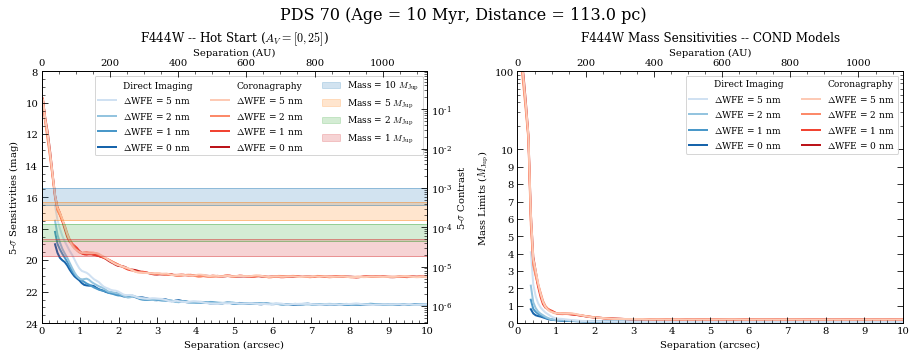

In [104]:
fig, axes = plot_compare2(curves_noref, obs_dict, filt_keys, wfe_list, age_sci, 
                          nsig=nsig, sat_max=sat_max)

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

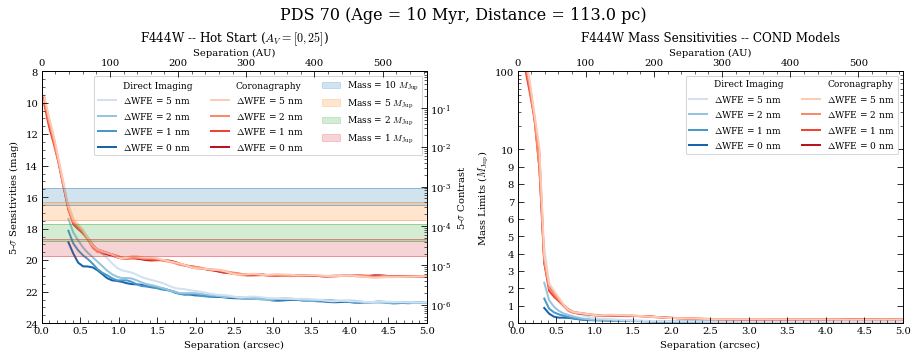

In [21]:
fig, axes = plot_compare2(curves_noref, obs_dict, filt_keys, wfe_list, age_sci, 
                          nsig=nsig, sat_max=sat_max)

fname = "{}_contrast_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)

### Images

In [196]:
# Add known planets
dL_arr  = np.array([6.9, 6.6]) # L-Band magnitudes
Lbp     = pynrc.read_filter('F360M') # Approx L-Band
rth_arr = [(0.18,150), (0.25,280)] # sep (asec), PA
for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    
    Lobs = S.Observation(obs.sp_sci, Lbp, binset=Lbp.wave)    
    Lmag_arr = Lobs.effstim('vegamag') + dL_arr
    print(Lobs.effstim('vegamag'), Lmag_arr)
    
    for i, Lmag in enumerate(Lmag_arr):
        obs.add_planet(rtheta=rth_arr[i], runits='asec', age=age_sci, mass=5, entropy=13,
                       renorm_args=(Lmag,'vegamag',Lbp))
        
    pl_mags = []
    for pl in obs.planets:
        sp = obs.planet_spec(**pl)
        renorm_args = pl['renorm_args']
        sp_norm = sp.renorm(*renorm_args)
        sp_norm.name = sp.name
        sp = sp_norm

        o = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
        pl_mags.append(o.effstim('vegamag'))
        
    print('Planet Mags:', key, pl_mags)
  

8.202853726222521 [15.10285373 14.80285373]
Planet Mags: F444W_none_none [14.16142876629511, 13.861428766295111]
8.203410290133434 [15.10341029 14.80341029]
Planet Mags: F444W_MASK335R_CIRCLYOT [14.156542926191031, 13.856542926191032]


In [191]:

pl_mags = []
for pl in obs.planets:
    sp = obs.planet_spec(**pl)
    renorm_args = pl['renorm_args']
    sp_norm = sp.renorm(*renorm_args)
    sp_norm.name = sp.name
    sp = sp_norm
    
    o = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
    pl_mags.append(o.effstim('vegamag'))


14.156542926191031
13.856542926191032


In [148]:
from copy import deepcopy
from pynrc.nrc_utils import fshift, fourier_imshift
def plot_hdulist(hdulist, xr=None, yr=None, ax=None, return_ax=False,
    cmap=None, scale='linear', vmin=None, vmax=None, axes_color='white',
    half_pix_shift=True):

    from webbpsf import display_psf

    if ax is None:
        fig, ax = plt.subplots()
    if cmap is None:
        cmap = matplotlib.rcParams['image.cmap']

    if half_pix_shift:
        oversamp = hdulist[0].header['OVERSAMP']
        shft = 0.5*oversamp
        hdul = deepcopy(hdulist)
        hdul[0].data = fshift(hdul[0].data, shft, shft)
    else:
        hdul = hdulist

    data = hdul[0].data
    if vmax is None:
        vmax = 0.75 * np.nanmax(data) if scale=='linear' else np.nanmax(data)
    if vmin is None:
        vmin = 0 if scale=='linear' else vmax/1e6

    ax, cb = display_psf(hdul, ax=ax, title='', colorbar=True, cmap=cmap,
                         scale=scale, vmin=vmin, vmax=vmax, return_ax=True)
    cb.set_label('Counts/sec')

    ax.set_xlim(xr)
    ax.set_ylim(yr)
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')


    ax.tick_params(axis='both', color=axes_color, which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color(axes_color)

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    
    if return_ax:
        return ax


In [170]:
# Ideal
wfe_ref = 0
wfe_roll = 0
hdul_dict_ideal = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=False, opt_diff=False,
                              oversample=4, PA1=0, PA2=0, exclude_noise=True)
# Roll Subtracted
wfe_ref = 10
wfe_roll = 5
hdul_dict = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=True, opt_diff=False,
                        oversample=4, PA1=-5, PA2=5)

F444W_none_none
F444W_MASK335R_CIRCLYOT
F444W_none_none
F444W_MASK335R_CIRCLYOT


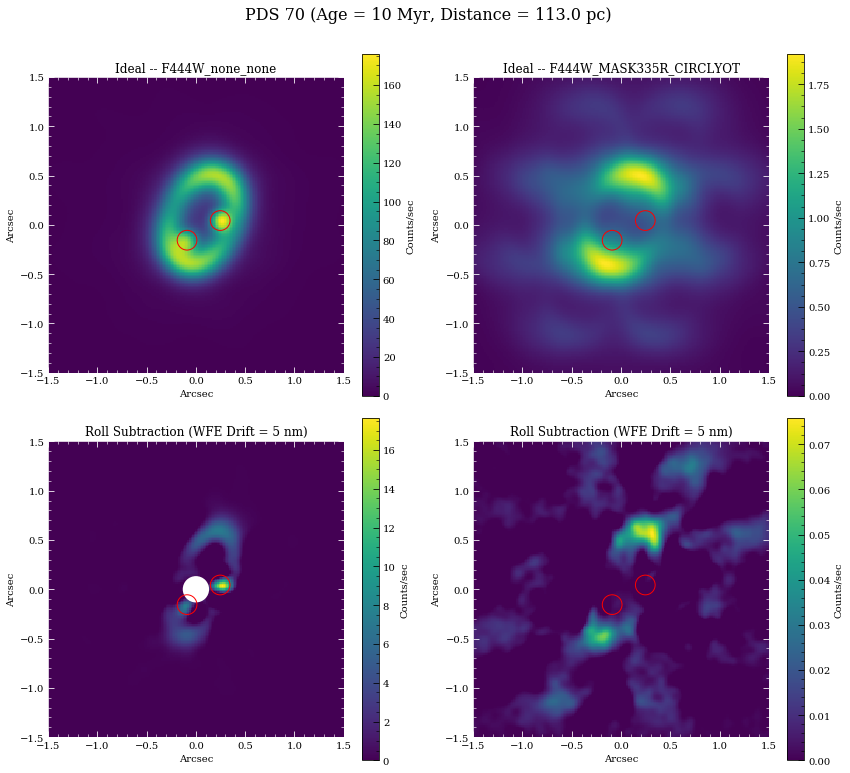

In [181]:
from copy import deepcopy
fig, axes_arr = plt.subplots(2,2, figsize=(12,11))

xylim = 1.5
xr = yr = np.array([-1,1])*xylim

axes = axes_arr[0]
for i, k in enumerate(filt_keys):
    hdul = hdul_dict_ideal[k]
    ax = axes[i]

    vmax = np.nanmax(hdul[0].data)
    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmax=vmax)
    ax.set_title('Ideal -- {}'.format(k))

axes = axes_arr[1]
for i, k in enumerate(filt_keys):
    ax = axes[i]

    hdul = hdul_dict[k]
    rho = nrc_utils.dist_image(hdul[0].data, pixscale=hdul[0].header['PIXELSCL'])
    vmax = np.nanmax(hdul[0].data[(rho>sat_max[i]) & (rho<xylim)])

    plot_hdulist(hdul, ax=ax, xr=xr, yr=yr, vmax=vmax)
    ax.set_title('Roll Subtraction (WFE Drift = {} nm)'.format(wfe_roll))
    
for i, sat_rad in enumerate(sat_max):
    ax = axes[i]
    if sat_rad>0:
        circle = matplotlib.patches.Circle([0,0], radius=sat_rad, lw=1, edgecolor='none', facecolor='white')
        ax.add_artist(circle);

# Location of planet
for pl in obs.planets:
    loc = (np.array(pl['xyoff_pix'])) * obs.pix_scale
    for ax in axes_arr.flatten():
        circle = matplotlib.patches.Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);

# Title
dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist)
title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

fig.suptitle(title_str, fontsize=16);

fig.tight_layout()
fig.subplots_adjust(top=0.92)

fname = "{}_images_compare.pdf".format(name_sci.replace(" ", ""))
fig.savefig(outdir+fname)